# Module Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.transforms.functional import to_tensor, to_pil_image
from torchvision import models
from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List, Union, Optional
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
import ast
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import time
import pandas as pd
from tqdm import tqdm
import neptune.new as neptune
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NGPU = torch.cuda.device_count()


# CSV Load

In [2]:
train_df = pd.read_csv('../Data/train_df',)
val_df = pd.read_csv('../Data/val_df')

In [3]:
len(train_df)

32377

In [4]:
train_df.head()

,file_name,width,height,category_id,bbox,class_name,obj_num
0,1000145_611.jpg,2800,2100,[0],"[[1502.0442959131642, 1074.98167049341, 167.64...",['줄자'],1
1,1000230_611.jpg,2800,2100,"[16, 16]","[[1517.9282652720503, 939.1521249172392, 142.5...","['너트', '너트']",2
2,1000231_611.jpg,2800,2100,[16],"[[1281.055125239361, 1085.916432508034, 120.86...",['너트'],1
3,1000232_611.jpg,2800,2100,[16],"[[933.8948551344544, 1233.435110574467, 138.58...",['너트'],1
4,1000234_611.jpg,2800,2100,[16],"[[1116.9281633753208, 983.669503208088, 160.26...",['너트'],1


# Encoder

In [5]:
labelEncoder = {}
fixencoder = {}
for i in range(24):
    fixencoder[i+333] = i
    
with open('../Data/Raw/Train/label/1000145_611.json') as f:
    json_obj = json.load(f)
    
    categories = json_obj['categories']
    for categorie in categories:
        labelEncoder[fixencoder[categorie['class_id']]] = categorie['class_name']

labelEncoder_Frame = pd.DataFrame(list(labelEncoder.items()), columns=["class_id","class_name"])
display(labelEncoder_Frame)

,class_id,class_name
0,0,줄자
1,5,건전지
2,10,버튼(동전)건전지
3,15,망치
4,1,못
5,6,나사못
6,11,볼트
7,16,너트
8,2,와셔
9,7,드라이버


# TRAINSFORM

In [6]:
IMAGE_SIZE = 600
scale = 1.0

train_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

val_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

# Data Loader

## Train Dataset

In [7]:
class Train_Dataset(Dataset):
    def __init__(self, df, label_encoder=None, is_training=False, transform = None, data_path = '../Data/Raw/Train/image'):
        self.file_name = df['file_name'].values #파일이름
        self.target = df['bbox'].apply(ast.literal_eval).tolist()#바운딩박스
        self.label = df['category_id'].apply(ast.literal_eval).tolist()#class이름
        self.objnum = df['obj_num'] #갯수
        self.class_name = df['class_name'].apply(ast.literal_eval).tolist()
        self.transform = transform
        self.label_encoder = label_encoder
        self.data_path = data_path
        
        print(f"데이터셋 생성 완료\n데이터셋 사이즈 : {len(self.file_name)}")
        
    def __getitem__(self,index):
        
        img_path = os.path.join(self.data_path, self.file_name[index])
        result = {}
        image = np.array(Image.open(img_path).convert('RGB'))
        target =[self.change_bbox_format(bbox) for bbox in self.target[index]]

        if self.transform:
            augmentation = self.transform(image = image, bboxes= target)
            image = augmentation['image']
            target = augmentation['bboxes']
            image = image.type(torch.float)
            
        result["boxes"] = torch.as_tensor(target,dtype = torch.float32)
        result["labels"] = torch.as_tensor(self.label[index],dtype = torch.int64)

        return image, result
    
    def __len__(self):
        return len(self.file_name)
    
    @staticmethod
    def change_bbox_format(bbox):
        x1,y1,w,h = bbox
        x2 = x1 + w
        y2 = y1 + h
        return float(x1),float(y1),float(x2),float(y2)

## Train 데이터셋 생성

In [8]:
train_ds = Train_Dataset(train_df,labelEncoder,transform = train_transforms)
val_ds = Train_Dataset(val_df,labelEncoder,transform = val_transforms)

데이터셋 생성 완료
데이터셋 사이즈 : 32377
데이터셋 생성 완료
데이터셋 사이즈 : 4287


## 샘플 이미지 확인

### 셈플 데이터 로드

In [9]:
img, targets = val_ds[100] # 데이터셋에서 가지고옴

### 시각화 함수 선언

In [10]:
# def show(img, targets, labelEncoder):
#     img = to_pil_image(img)
#     draw = ImageDraw.Draw(img)
#     targets = targets
#     width, height = img.size
    
#     for target,label in zip(targets,labels):
#         class_id = int(label)
#         bbox = target[:4]
#         draw.rectangle(((bbox[0], bbox[1]), (bbox[2],bbox[3] )), outline=(0,255,0), width=1)
#     plt.imshow(np.array(img))

### 시각화

In [11]:
# plt.figure(figsize=(10,10))
# show(img, targets, labels,labelEncoder)

# RetinaNet Model 만들기

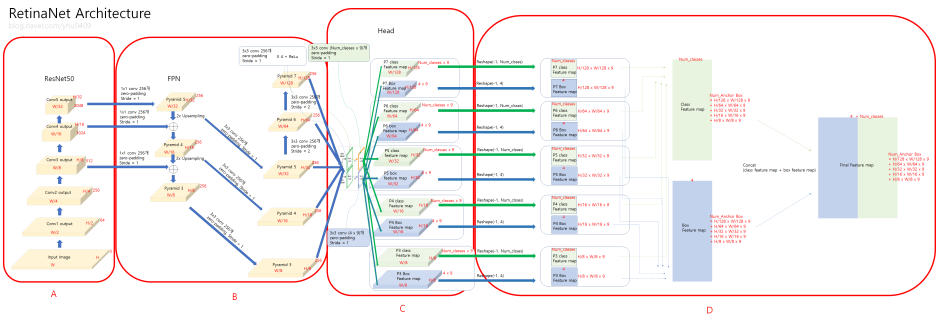

## DataLoader 

In [12]:
# def collate_fn(batch):
#     images = []
#     targets = []
#     labels = []
    
#     for image, target, label in batch:
#         images.append(image)
#         targets.append(target)
#         labels.append(label)
        
#     images = torch.stack(images,dim=0)
#     targets = [torch.tensor(item) for item in targets]
#     labels = [torch.tensor(item) for item in labels]
#     print(targets)
#     print(labels)
#     result = [torch.cat([t, l]) for t, l in zip(targets, labels)]

    
#     print(len(images), len(result))
    
#     return images, result

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
def makeDataLoader(params):
    batch_size = params['batch_size']
    train_dataloader = DataLoader(train_ds,batch_size=batch_size,collate_fn=collate_fn)
    val_dataloader = DataLoader(val_ds,batch_size=batch_size,collate_fn=collate_fn)
    
    return train_dataloader, val_dataloader

# Road Pretrain Model

In [15]:
def makeModel(params):
    num_classes = params['num_classes']
    model_name = params['model_name']
    if model_name == 'RetinaNet':
        model = models.detection.retinanet_resnet50_fpn(num_classes= num_classes).to(device)
        return model
    else:
        raise Exception("정의 되지 않은 모델 호출")

# Optimizer ,lr scheduler

In [16]:
def setScheduler(params,model):
    opt_name = params['optimizer']
    scheduler_name = params['scheduler']
    init_lr = params['learning_rate']
    factor = params['factor']
    patience = params['patience']
    
    opt = optim.Adam(model.parameters(), lr=init_lr)
    lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=factor, patience=patience)
    
    return opt, lr_scheduler

In [17]:
# 현재 lr 계산
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(params):
    num_epochs=params['num_epochs']
    opt=params['optimizer']
    lr_scheduler=params['scheduler']
    path2weights=params['path2weights']
    model = makeModel(params)
#     model = torch.nn.DataParallel(model, device_ids=list(range(NGPU)))
#     torch.multiprocessing.set_start_method('spawn')
    opt, lr_scheduler = setScheduler(params,model)
    train_dl, val_dl= makeDataLoader(params)

    best_loss = float('inf')
    torch.save(model.state_dict(),path2weights)
    current_lr = 0


    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0
        train_loss = 0
        val_loss = 0
        current_lr = get_lr(opt)
        model.train()
        for images, targets in train_dl:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            opt.zero_grad()
            losses.backward()
            opt.step()
            
            train_loss += losses 

        model.eval()
        with torch.no_grad():
            for images, targets in val_dl:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                val_loss += losses

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(),path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)

        if current_lr != get_lr(opt):
            print('Loading best model weights')
            model.load_state_dict(torch.load(path2weights))

#         run["train/loss"].append(train_loss)
#         run["val/loss"].append(val_loss)
        
        print('train loss: %.6f, val loss: %.6f, time: %.4f min' %(train_loss, val_loss, (time.time()-start_time)/60))

    model.load_state_dict(torch.load(path2weights))
    return model

In [18]:
# run = neptune.init_run(
#     project="DigitalMediaLab/SmallObj",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDljNTU0ZC03NGM4LTQwNzEtYTBlNi0yYzE1OGZiNmE1MjkifQ==",
# )  # your credentials
# run_id = run["sys/id"].fetch()
run_id = 100

params = {
    'num_epochs':100,
    'num_classes' : 24,
    'batch_size' : 2,
    'optimizer':"Adam",
    'loss_func':"FocalLoss",
    'model_name' : 'RetinaNet',
    'learning_rate' : 0.01,
    'scheduler':"ReduceLROnPlateau",
    'factor' : 0.1,
    'patience' : 15,
    'tag' : 'Retina torchvision model',
    'path2weights': f"./models/{run_id}.pt"
}

# run["parameters"] = params
# run["train/dataset"].track_files('../Data/train_df')
# run["val/dataset"].track_files('../Data/val_df')

model = train_val(params)

# run["model_weights"].upload(path2weight)
# run.stop()

KeyboardInterrupt: 

In [ ]:
run.stop()